In [1]:
import os
import json
import openai
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

from dotenv import load_dotenv
load_dotenv('/home/pervinco/LLM-tutorials/keys.env')
openai_api_key = os.getenv('GRAVY_LAB_OPENAI')

from src.data_processor import translate_and_convert_to_string, process_vision_result, extract_workstyle_info

In [2]:
n_iter = 100
temperature = 0.1
gt_path = "./data/amy_gt.json"
data_path = "./data/amy_culture_fit.json"

output_dir = "./result"
csv_file_name = f"CoT_Vision_{n_iter}times.csv"

In [3]:
client = openai.OpenAI(api_key=openai_api_key)

In [4]:
with open(data_path, 'r', encoding='utf-8') as file:
    hr_data_dict = json.load(file)

with open(data_path, 'r', encoding="utf-8") as file:
    gt_data_dict = json.load(file)

In [5]:
processed_data_summary = translate_and_convert_to_string(hr_data_dict['summaryResult'])
vision_data = process_vision_result(hr_data_dict['visionResult'], hr_data_dict['summaryResult'])
workstyle_data = extract_workstyle_info(hr_data_dict['workstyleResult'], hr_data_dict['summaryResult'])

In [6]:
print(processed_data_summary)


채용 권장 수준, 입사 후 적응 기간, 조기 퇴사 가능성 : 
조기 퇴사 가능성: 낮음
입사 후 적응 기간: 보통
채용 권장 수준: 보통

검사 항목별 결과 : 
5) 사고방식이 기업 비전,가치관에 부합하는가?: 매우 그렇다
2) 타 팀, 타 구성원과의 원만한 협업을 기대할 수 있는가?: 그렇다
3) 경영진, 상급자와의 원활한 소통을 기대할 수 있는가?: 그렇다
4) 기업이 추구하는 일하는 방식과 부합하는가?: 매우 그렇다
1) 구성원들과 원활한 소통이 가능한가?: 그렇다

이직 스트레스 요인 : 
공정인사

위험 성향 : 오만형


In [7]:
vision_prompt = """
주어진 데이터는 기업 비전과 피검사자의 비전 점수를 기반으로 분석한 결과입니다. 다음은 분석 단계입니다:

1. **기업의 비전 상위 3개 선별**:
   기업의 비전에서 점수가 높은 상위 3개의 키워드를 선택합니다. 예를 들어, ["전문성", "사회공헌", "성과"]와 같이 구성됩니다.

2. **피검사자의 비전 상위 3개 선별**:
   피검사자의 비전에서 점수가 높은 상위 3개의 키워드를 선택합니다. 예를 들어, ["창조", "열정", "혁신"]와 같이 구성됩니다.

3. **동일 키워드 점수 차이 분석**:
   기업과 피검사자 상위 3개 키워드 중 동일한 키워드가 있을 경우, 두 점수의 차이를 계산합니다. 이를 "equal_top3"라 부릅니다. 차이가 큰 경우 우려를 표현하며, 차이가 작은 경우 긍정적인 평가를 제공합니다. 예를 들어:
   - "전문성" (기업: 4.6, 피검사자: 0.38) → 큰 차이로 인해 우려 사항.
   - "사회공헌" (기업: 4.2, 피검사자: 4.17) → 매우 유사함으로 긍정 평가.

4. **일치하지 않는 키워드 분석**:
   기업 상위 3개 키워드와 일치하지 않는 피검사자의 상위 키워드를 "noeq_top3"로 구분합니다. 이를 통해 피검사자가 독자적으로 높은 관심을 가진 비전을 파악합니다. 예를 들어, "창조", "열정".

5. **결과 서술**:
   - 기업이 중요시하는 비전과 피검사자가 중요시하는 비전을 각각 서술합니다.
   - "equal_top3"에서 차이가 1.8 이상인 키워드에 대해 우려를 표현하되, 부정적인 내용은 피합니다.
   - "equal_top3"에서 차이가 0.5 이하인 경우 긍정적으로 표현합니다.
   - 피검사자의 점수가 기업보다 높은 경우, 강한 긍정과 추가적 가치 창출 가능성을 언급합니다.

6. **최종 결과 문장 생성**:
   300자 이내의 문장으로 피검사자가 기업 비전과 어느 정도 정렬되어 있는지를 서술합니다. 
   반드시 존댓말을 사용하며, 피검사자가 기업에 적합한지 겸손한 어조로 표현합니다. 
   문장의 끝부분에는 "전반적으로 피검사자와 기업간 비전 fit은 [높음, 보통, 낮은] 편입니다." 로 마무리 지어 주세요.
   또한 아래 예시를 참고하여 작성합니다:

   "기업은 전문성, 성과, 사회공헌을 중요시하며, 피검사자는 창조, 열정, 혁신에 높은 가치를 두고 있습니다. 피검사자는 사회공헌에 대한 관심이 기업과 유사하며, 이는 긍정적으로 평가됩니다. 그러나 전문성에 대한 피검사자의 관심이 상대적으로 낮아 우려가 있을 수 있습니다. 반면, 피검사자는 성과에 대한 관심이 기업보다 낮지만, 창조와 열정에서 높은 점수를 보이며 기업에 추가적인 가치를 제공할 가능성이 있습니다. 전반적으로 피검사자와 기업간 비전 fit은 보통입니다."
"""

In [8]:
user_vision_input = f"""
기업의 비전 데이터: {hr_data_dict["visionResult"]['company']}
피검사자의 비전 데이터: {hr_data_dict["visionResult"]['compute']}
"""

In [9]:
def run_openai_api(n_iter, vision_prompt, user_vision_input, temperature):
    results = []
    for i in range(n_iter):
        completion = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": vision_prompt},
                {"role": "user", "content": user_vision_input}
            ],
            temperature=temperature
        )
        response_content = completion.choices[0].message.content
        results.append({
            "iteration": i + 1,
            "response": response_content
        })
    return results

In [10]:
print(f"company top3 : {vision_data['company_top_keywords']}\n")
print(f"compute top3 : {vision_data['compute_top_keywords']}\n")

print(f"compnay remain : {vision_data['company_remaining_keywords']}\n")
print(f"compute remain : {vision_data['compute_remaining_keywords']}\n")

print(f"fianl eval : {vision_data['compute_vision_total_evalation']}")

company top3 : 전문성:4.6, 성과:4.2, 사회공헌:4.2

compute top3 : 창조:5.0, 열정:5.0, 혁신:4.58

compnay remain : 상생:4.0, 최고지향:3.6, 고객:3.0, 성장:3.0

compute remain : 신속성:4.23, 사회공헌:4.17, 고객:4.0, 성장:3.85, 소통:3.75, 성과:3.33, 도전:3.21, 상생:3.13, 최고지향:2.78, 문제해결:2.5, 인재:2.27, 즐거움:1.5, 전문성:0.38

fianl eval : 보통


In [11]:
results = run_openai_api(n_iter, vision_prompt, user_vision_input, temperature)

In [12]:
df = pd.DataFrame(results)
df.to_csv(os.path.join(output_dir, csv_file_name), index=False, encoding='utf-8-sig')
print(f"Results saved to {os.path.join(output_dir, csv_file_name)}")

Results saved to ./result/CoT_Vision_100times.csv


In [13]:
embed_model = "text-embedding-3-large"
df = pd.read_csv(f"{output_dir}/{csv_file_name}")
responses = df["response"].tolist()

In [14]:
def calculate_embedding_similarity_and_embeddings(responses):
    embeddings = []
    for response in responses:
        embedding_response = client.embeddings.create(
            input=response,
            model="text-embedding-3-small"
        )
        embeddings.append(embedding_response.data[0].embedding)

    embeddings = np.array(embeddings)  # Convert list to NumPy array
    similarity_matrix = cosine_similarity(embeddings)
    mean_similarity = similarity_matrix.mean()
    
    return mean_similarity, embeddings

In [15]:
mean_similarity, embeddings = calculate_embedding_similarity_and_embeddings(df["response"].tolist())

In [16]:
def lexical_overlap(response1, response2):
    words1 = set(response1.split())
    words2 = set(response2.split())
    return len(words1 & words2) / len(words1 | words2)

In [17]:
lexical_similarities = [
    lexical_overlap(responses[i], responses[j])
    for i in range(len(responses)) for j in range(i + 1, len(responses))
]
mean_lexical_similarity = sum(lexical_similarities) / len(lexical_similarities)

In [18]:
print(f"Semantic Similarity (mean): {mean_similarity:.2f}")
print(f"Lexical Overlap (mean): {mean_lexical_similarity:.2f}")

Semantic Similarity (mean): 1.00
Lexical Overlap (mean): 0.96


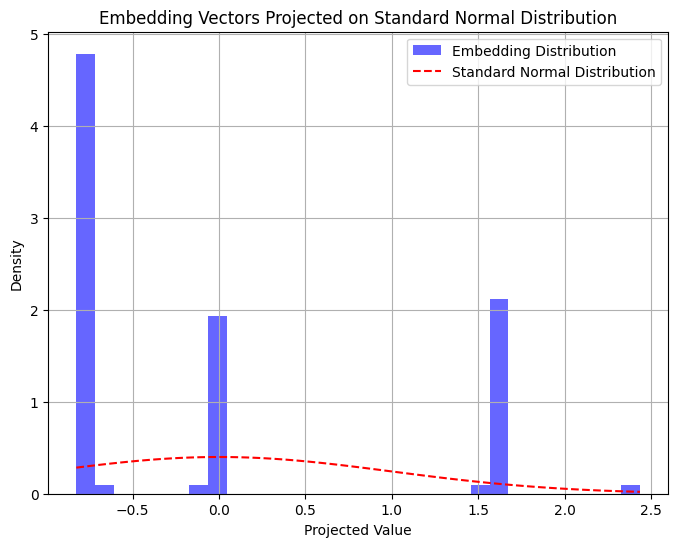

In [23]:
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler

# 1. 임베딩 벡터 정규화 (평균 0, 분산 1)
scaler = StandardScaler()
normalized_embeddings = scaler.fit_transform(embeddings)

# 2. 특정 축으로 1D 투영 (예: 첫 번째 차원)
projected_values = normalized_embeddings[:, 0]  # 첫 번째 차원 선택

# 3. 히스토그램 계산
hist, bins = np.histogram(projected_values, bins=30, density=True)

# 4. 정규분포 곡선 계산
x = np.linspace(projected_values.min(), projected_values.max(), 100)
pdf = norm.pdf(x, loc=0, scale=1)  # 평균 0, 표준편차 1인 정규분포

# 5. 시각화
plt.figure(figsize=(8, 6))

# 히스토그램
plt.hist(projected_values, bins=30, density=True, alpha=0.6, color='blue', label='Embedding Distribution')

# 정규분포 곡선
plt.plot(x, pdf, 'r--', label='Standard Normal Distribution')

# 그래프 설정
plt.title('Embedding Vectors Projected on Standard Normal Distribution')
plt.xlabel('Projected Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)

# 결과 저장
output_dir = "output_directory"  # 필요한 경로로 변경
os.makedirs(output_dir, exist_ok=True)
plt.savefig(os.path.join(output_dir, "embedding_normal_distribution.png"))
plt.show()